First run this, then restart the session and run this again (THIS IS VERY IMPORTANT OTHERWISE THE PROGRAM WON'T EXECUTE)

In [12]:
# ==== Install required packages (run these only if not already installed) ====
# Uncomment and run these commands if using a new environment like Google Colab
# They install all libraries needed for data analysis, NLP, topic modeling, and visualization

!pip install pandas tqdm nltk spacy pyldavis matplotlib wordcloud numpy==1.26.4 gensim==4.3.3 scipy==1.13.1
!python -m spacy download en_core_web_sm    # Downloads the small English language model for spaCy

# ==== Imports: group similar ones together for readability ====

# Core data science libraries
import pandas as pd                    # For data manipulation and analysis
import numpy as np                     # For numerical computations and arrays

# Text processing and utility libraries
import re                              # Regular expressions for advanced string/text operations
from tqdm import tqdm                  # Adds progress bars to loops for tracking
import nltk                            # Natural Language Toolkit for text preprocessing tasks
from nltk.corpus import stopwords      # List of common stopwords for filtering out unimportant words

# NLP and lemmatization
import spacy                           # Industrial-strength NLP library (used for lemmatization)

# Visualization libraries
import matplotlib.pyplot as plt        # Standard plotting library for charts and graphs
from wordcloud import WordCloud        # For generating word cloud visualizations

from collections import Counter        # For counting hashable objects (like word frequencies)

# Gensim and topic modeling imports
from gensim import corpora                     # For creating a dictionary and corpus needed for LDA
from gensim.models import LdaModel, CoherenceModel   # LDA for topic modeling, CoherenceModel for evaluation

# Visualization support for LDA results
import pyLDAvis                                    # Interactive LDA visualization tool
import pyLDAvis.gensim_models as gensimvis         # Adapter for using pyLDAvis with gensim models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
# ==== Download required NLTK data ====
nltk.download('stopwords')  # Download the list of English stopwords (common words like 'the', 'is', etc.)

# ==== Load spaCy English language model (disable parser/ner for speed) ====
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])  # Load spaCy English model for lemmatization

# ==== Load the Twitter dataset ====
# Replace with your actual file path if needed
df = pd.read_csv('twitter_dataset.csv')  # Read the dataset containing tweets from a CSV file

# Preview first 5 rows of the original data
print("First 5 rows of raw data:")
print(df.head())  # Display the first 5 rows to understand the raw data structure

# ==== Set of English stopwords ====
stop_words = set(stopwords.words('english'))  # Create a set of English stopwords for quick lookup

# ==== Function to clean raw tweet text ====
def clean_tweet(text):
    """
    Cleans tweet text by removing URLs, mentions, punctuation, single characters, and normalizing whitespace.
    - Keeps hashtag words but removes the '#' symbol.
    - Converts text to lowercase.
    """
    text = re.sub(r'http\S+|www\S+', '', text)           # Remove URLs
    text = re.sub(r'@\w+', '', text)                     # Remove @mentions
    text = re.sub(r'#', '', text)                        # Remove '#' from hashtags but keep the word
    text = re.sub(r'[^A-Za-z\s]', '', text)              # Remove punctuation and numbers
    text = text.lower()                                  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)                     # Replace multiple spaces with single space
    text = re.sub(r'\b\w\b', '', text)                   # Remove single character words (e.g., "a", "I")
    return text.strip()                                  # Remove leading/trailing spaces and return

# ==== Function to preprocess tweet (clean + lemmatize + remove stopwords) ====
def preprocess(text):
    """
    Full preprocessing pipeline:
    1. Clean the tweet text.
    2. Lemmatize words using spaCy.
    3. Remove stopwords and short tokens (<=2 chars).
    4. Remove duplicate tokens for each tweet.
    Returns a space-separated string of clean tokens.
    """
    text = clean_tweet(text)  # Clean the raw tweet text
    doc = nlp(text)           # Lemmatize using spaCy
    # Keep lemmatized words that are not stopwords and longer than 2 characters
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and len(token.text) > 2]
    tokens = list(dict.fromkeys(tokens))  # Remove repeated words in the same tweet
    return ' '.join(tokens)               # Join the tokens back into a single string

# ==== Apply preprocessing to each tweet (progress bar shown with tqdm) ====
tqdm.pandas()  # Enable tqdm progress_apply for pandas
df['Clean_Text'] = df['Text'].progress_apply(preprocess)  # Apply preprocessing to each tweet, show progress

# ==== Remove duplicate tweets (if any) ====
before_dupes = len(df)  # Store original number of tweets
df = df.drop_duplicates(subset='Clean_Text').reset_index(drop=True)  # Drop duplicate tweets based on cleaned text
after_dupes = len(df)   # Store new number after removing duplicates
print(f"\nRemoved {before_dupes - after_dupes} duplicate tweets based on cleaned text.")

# ==== Show a comparison of original vs cleaned text for first 5 tweets ====
print("\nOriginal vs. Cleaned tweets (sample):")
for i in range(5):
    print(f"Original: {df.loc[i, 'Text']}")        # Print the original tweet
    print(f"Cleaned:  {df.loc[i, 'Clean_Text']}\n")# Print the cleaned and processed tweet

# ==== Remove tweets with fewer than 3 words after cleaning ====
initial_count = len(df)  # Store number of tweets before filtering
# Keep only tweets that have 3 or more words after cleaning
df = df[df['Clean_Text'].str.split().str.len() >= 3].reset_index(drop=True)
final_count = len(df)    # Store number after filtering
print(f"\nRemoved {initial_count - final_count} short/empty tweets. Remaining tweets after cleaning: {final_count}")

# ==== Tweet length statistics after cleaning ====
tweet_lengths = df['Clean_Text'].str.split().str.len()  # Get list of token counts per tweet
print("\n--- Tweet Length Stats (After Cleaning) ---")
print(tweet_lengths.describe())  # Print summary statistics for tweet lengths

# ==== Top 10 Most Frequent Words (After Cleaning) ====
# Combine all tokens from all tweets into a flat list
all_tokens = []
for tweet in df['Clean_Text']:
    all_tokens.extend(tweet.split())

top_words = Counter(all_tokens).most_common(10)  # Find 10 most common words
print("\n--- Top 10 Most Frequent Words (After Cleaning) ---")
for word, count in top_words:
    print(f"{word}: {count}")  # Print each word with its frequency


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First 5 rows of raw data:
   Tweet_ID        Username  \
0         1         julie81   
1         2   richardhester   
2         3  williamsjoseph   
3         4     danielsmary   
4         5      carlwarren   

                                                Text  Retweets  Likes  \
0  Party least receive say or single. Prevent pre...         2     25   
1  Hotel still Congress may member staff. Media d...        35     29   
2  Nice be her debate industry that year. Film wh...        51     25   
3  Laugh explain situation career occur serious. ...        37     18   
4  Involve sense former often approach government...        27     80   

             Timestamp  
0  2023-01-30 11:00:51  
1  2023-01-02 22:45:58  
2  2023-01-18 11:25:19  
3  2023-04-10 22:06:29  
4  2023-01-24 07:12:21  


100%|██████████| 10000/10000 [00:30<00:00, 327.79it/s]



Removed 0 duplicate tweets based on cleaned text.

Original vs. Cleaned tweets (sample):
Original: Party least receive say or single. Prevent prevent husband affect. May himself cup style evening protect. Effect another themselves stage perform.
Possible try tax share style television with. Successful much sell development economy effect.
Cleaned:  party least receive say single prevent husband affect may cup style evening protect effect another stage perform possible try tax share television successful much sell development economy

Original: Hotel still Congress may member staff. Media draw buy fly. Identify on another turn minute would.
Local subject way believe which question some message. Own all imagine join agency indicate.
Cleaned:  hotel still congress may member staff medium draw buy fly identify another turn minute would local subject way believe question message imagine join agency indicate

Original: Nice be her debate industry that year. Film where generation push discov

In [14]:
# ==== 1. Tokenize cleaned tweets ====
# For each cleaned tweet, split the string into a list of words (tokens)
texts = [tweet.split() for tweet in df['Clean_Text']]

# ==== 2. Build the Gensim Dictionary ====
# Create a dictionary that assigns a unique integer ID to each unique word in the dataset
dictionary = corpora.Dictionary(texts)

# ==== 3. Filter extremes (remove rare and overly common words) ====
# Keep only the words that appear in at least 5 tweets (documents),
# and remove words that appear in more than 50% of tweets (very common words, likely not informative)
dictionary.filter_extremes(no_below=5, no_above=0.5)

print(f"\nTotal unique words in dictionary after filtering: {len(dictionary)}")

# ==== 4. Convert each tweet into a Bag-of-Words vector ====
# Represent each tweet as a list of (word_id, count) tuples using the filtered dictionary
corpus = [dictionary.doc2bow(text) for text in texts]

# ==== 5. Show a sample of the Bag-of-Words representation for the first tweet ====
# Print the first 10 (word_id, count) pairs for the first tweet
print("\nSample Bag-of-Words vector for first tweet:")
print(corpus[0][:10])  # Each tuple: (token ID, number of times that token appears in the tweet)

# ==== 6. Show corpus-level statistics (optional but useful for EDA/report) ====
# Print the total number of documents (tweets) in the corpus
print(f"\nCorpus contains {len(corpus)} documents (tweets).")
# Calculate statistics about the number of unique tokens per tweet
lengths = [len(doc) for doc in corpus]
print(f"Average number of unique tokens per tweet (after filtering): {np.mean(lengths):.2f}")
print(f"Maximum number of unique tokens in a tweet: {np.max(lengths)}")
print(f"Minimum number of unique tokens in a tweet: {np.min(lengths)}")

# ==== 7. Show top 20 tokens in the dictionary ====
# Count total occurrences of each token across all tweets
token_freqs = Counter()
for bow in corpus:
    for token_id, count in bow:
        token_freqs[token_id] += count

# Get the 20 most frequent tokens and print their string value and count
top_tokens = token_freqs.most_common(20)
print("\nTop 20 tokens by frequency in corpus (after filtering):")
for token_id, count in top_tokens:
    print(f"{dictionary[token_id]}: {count}")  # Print the word and how many times it appears in the corpus



Total unique words in dictionary after filtering: 869

Sample Bag-of-Words vector for first tweet:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]

Corpus contains 10000 documents (tweets).
Average number of unique tokens per tweet (after filtering): 29.64
Maximum number of unique tokens in a tweet: 42
Minimum number of unique tokens in a tweet: 11

Top 20 tokens by frequency in corpus (after filtering):
well: 773
include: 683
leave: 612
good: 602
think: 564
feel: 557
meet: 438
build: 432
hard: 411
tax: 400
maybe: 391
yard: 389
success: 388
add: 388
forget: 387
food: 387
exactly: 386
high: 386
man: 385
boy: 384


In [15]:
# ==== Coherence Tuning: Find Optimal Number of Topics ====
coherence_scores = []                    # List to store (num_topics, coherence) for each run
topic_nums = [5, 7, 10, 12, 15]          # Range of topic numbers to test (can adjust as needed)

# Loop through each number of topics, train an LDA model, and calculate coherence score
for n in topic_nums:
    lda = LdaModel(
        corpus=corpus,                   # Bag-of-words representations of tweets
        id2word=dictionary,              # Mapping of token IDs to words
        num_topics=n,                    # Number of topics to generate
        random_state=42,                 # Ensures results are reproducible
        passes=10,                       # Number of passes through the corpus (higher = more thorough, slower)
        alpha='auto'                     # Automatic hyperparameter tuning for topic distribution
    )
    # Calculate coherence score for model (higher is better)
    coherence = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append((n, coherence))       # Store the number of topics and its coherence score
    print(f'Num topics: {n}, Coherence: {coherence:.4f}')  # Print result for this run

# ==== Pick the number of topics with the highest coherence score ====
# Find the topic number with the highest coherence score for best model quality
best_num_topics, best_coherence = max(coherence_scores, key=lambda x: x[1])
print(f"\nBest number of topics (by coherence): {best_num_topics} (coherence: {best_coherence:.4f})")

# ==== Train Final LDA Model on Chosen Topic Number ====
NUM_TOPICS = best_num_topics  # You can override this if you want to pick a different number manually
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True        # Allows model to keep per-word topic assignments
)

# ==== Save the model for reuse ====
lda_model.save('lda_model_twitter')  # Save the trained model to disk so it can be reloaded later

# ==== Assign dominant topic per tweet ====
def get_dominant_topic(bow):
    """
    Returns the topic ID with the highest probability for a tweet's BoW vector.
    """
    topics = lda_model.get_document_topics(bow)             # List of (topic_id, probability) for this tweet
    return max(topics, key=lambda x: x[1])[0] if topics else None   # Select topic with highest probability

# Apply the function to each tweet's BoW vector and store the result in the DataFrame
df['Dominant_Topic'] = [get_dominant_topic(bow) for bow in corpus]

# ==== Print sample tweets for each topic ====
# For each topic, print a few randomly chosen tweets that the model assigned to this topic
for topic_num in range(NUM_TOPICS):
    print(f"\nSample tweets for Topic {topic_num}:")
    samples = df[df['Dominant_Topic'] == topic_num].sample(3)['Text']  # Randomly pick 3 tweets for the topic
    for tweet in samples:
        print("-", tweet)


Num topics: 5, Coherence: 0.2521
Num topics: 7, Coherence: 0.2501
Num topics: 10, Coherence: 0.2588
Num topics: 12, Coherence: 0.2541
Num topics: 15, Coherence: 0.2576

Best number of topics (by coherence): 10 (coherence: 0.2588)

Sample tweets for Topic 0:
- Be woman chance easy. Prepare source century answer. Baby remember talk.
Responsibility area democratic bit expert development head do. Work general example region. School general add class hard.
Democratic beyond meeting herself television movie.
- Interest those yourself item sense leave. Industry whose north child find race compare. According example question own someone activity political effort.
Just probably single quite. Safe work sort Mr office answer allow former. Sometimes up idea pressure modern never.
- Stuff call election show. Add behind hospital cup address without.
Culture them form education full study cut. Seven operation very too image chance do toward. And at interview provide fund particular.
Price employee le

In [16]:
# ==== Show Top Words for Each Topic (to help with labeling) ====
# For each topic, display the top 10 words that best represent that topic.
# This helps in interpreting and labeling the topics in human-readable terms.

for topic_num in range(NUM_TOPICS):
    # Get the top 10 words (and their probabilities, which we ignore here) for this topic
    top_words = ', '.join([word for word, _ in lda_model.show_topic(topic_num, 10)])
    print(f"Topic {topic_num} Top Words: {top_words}")  # Print the topic number and its most significant words

Topic 0 Top Words: woman, education, thus, back, compare, contain, significant, brother, wall, kind
Topic 1 Top Words: well, great, step, far, prepare, around, operation, ability, discuss, decision
Topic 2 Top Words: reach, since, rise, appear, position, economic, art, audience, address, tough
Topic 3 Top Words: offer, either, fact, foot, change, difference, suggest, run, sign, cup
Topic 4 Top Words: true, throughout, lot, look, leave, admit, sort, continue, rule, yard
Topic 5 Top Words: real, stage, bill, system, thing, mother, sell, relate, career, society
Topic 6 Top Words: inside, speak, evening, know, north, cause, race, alone, well, sign
Topic 7 Top Words: build, behavior, begin, tax, could, research, item, often, note, may
Topic 8 Top Words: strategy, somebody, decide, adult, hospital, compare, official, capital, record, structure
Topic 9 Top Words: commercial, health, explain, nature, write, customer, especially, feel, threat, name


In [17]:
# Define human-readable labels for each topic.
# The key is the topic number (as identified by the LDA model),
# and the value is a descriptive string summarizing that topic's main themes.
topic_labels = {
    0: "Education, Family & Society",
    1: "Work, Progress & Decisions",
    2: "Politics, Economics & Public Affairs",
    3: "Change, Offerings & Differences",
    4: "Life Events & Relationships",
    5: "Career, Money & Social Systems",
    6: "Communication & Social Issues",
    7: "Behavior, Research & Innovation",
    8: "Strategy, Health & Public Sector",
    9: "Commerce, Health & Customer Service"
}

# Map the human-readable topic labels to each tweet in the DataFrame,
# replacing the topic number with the descriptive label.
df['Topic_Label'] = df['Dominant_Topic'].map(topic_labels)


In [18]:
# ==== Table: Show 3 sample tweets per topic ====

sampled_tweets = []  # List to store sample tweet data for each topic

# Loop through each topic number
for topic_num in range(NUM_TOPICS):
    # Randomly select 3 tweets assigned to this topic (same random seed for reproducibility)
    samples = df[df['Dominant_Topic'] == topic_num].sample(3, random_state=42)[['Text', 'Clean_Text']]
    # For each sampled tweet, append topic info and tweet content to the list
    for i, row in samples.iterrows():
        sampled_tweets.append([
            topic_num,                   # Topic number
            topic_labels[topic_num],     # Human-readable topic label
            row['Text'],                 # Original tweet text
            row['Clean_Text']            # Cleaned/preprocessed tweet text
        ])

import pandas as pd
# Create a DataFrame to tabulate the results for easier viewing and export
sample_table = pd.DataFrame(
    sampled_tweets,
    columns=['Topic #', 'Topic Label', 'Original Tweet', 'Cleaned Tweet']
)

print(sample_table.head(30))  # Show first 30 rows of the table as an example

# Save the sample table as a CSV file (for inclusion in your report or appendix)
sample_table.to_csv('sample_tweets_per_topic.csv', index=False)


    Topic #                           Topic Label  \
0         0           Education, Family & Society   
1         0           Education, Family & Society   
2         0           Education, Family & Society   
3         1            Work, Progress & Decisions   
4         1            Work, Progress & Decisions   
5         1            Work, Progress & Decisions   
6         2  Politics, Economics & Public Affairs   
7         2  Politics, Economics & Public Affairs   
8         2  Politics, Economics & Public Affairs   
9         3       Change, Offerings & Differences   
10        3       Change, Offerings & Differences   
11        3       Change, Offerings & Differences   
12        4           Life Events & Relationships   
13        4           Life Events & Relationships   
14        4           Life Events & Relationships   
15        5        Career, Money & Social Systems   
16        5        Career, Money & Social Systems   
17        5        Career, Money & Social Syst

In [19]:
# Count the number of occurrences for each unique topic label in the 'Topic_Label' column
topic_counts = df['Topic_Label'].value_counts()

# Print a header to indicate what the output represents
print("\nNumber of tweets per topic:")

# Print the counts for each topic, showing how many tweets belong to each topic
print(topic_counts)



Number of tweets per topic:
Topic_Label
Career, Money & Social Systems          1260
Strategy, Health & Public Sector        1118
Politics, Economics & Public Affairs    1023
Communication & Social Issues            973
Life Events & Relationships              971
Commerce, Health & Customer Service      968
Education, Family & Society              961
Work, Progress & Decisions               938
Change, Offerings & Differences          919
Behavior, Research & Innovation          869
Name: count, dtype: int64


In [20]:
# ==== Ensure 'Timestamp' is in datetime format and extract 'Month' ====
# Convert the 'Timestamp' column to pandas datetime objects (if it's not already).
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create a new column 'Month' containing only the year and month (YYYY-MM format) for each tweet.
df['Month'] = df['Timestamp'].dt.to_period('M').astype(str)

# ==== Group by Month and Topic_Label, then count tweets ====
# Group the DataFrame by 'Month' and 'Topic_Label', then count the number of tweets for each combination.
# Use unstack to create a table where rows are months and columns are topic labels; fill missing values with 0.
topic_time_counts = df.groupby(['Month', 'Topic_Label']).size().unstack(fill_value=0)

print("\nNumber of tweets per topic per month (first few rows):")
print(topic_time_counts.head())  # Display the first few rows of the resulting table



Number of tweets per topic per month (first few rows):
Topic_Label  Behavior, Research & Innovation  Career, Money & Social Systems  \
Month                                                                          
2023-01                                  202                             279   
2023-02                                  164                             267   
2023-03                                  207                             308   
2023-04                                  178                             265   
2023-05                                  118                             141   

Topic_Label  Change, Offerings & Differences  \
Month                                          
2023-01                                  214   
2023-02                                  172   
2023-03                                  214   
2023-04                                  208   
2023-05                                  111   

Topic_Label  Commerce, Health & Customer Servi

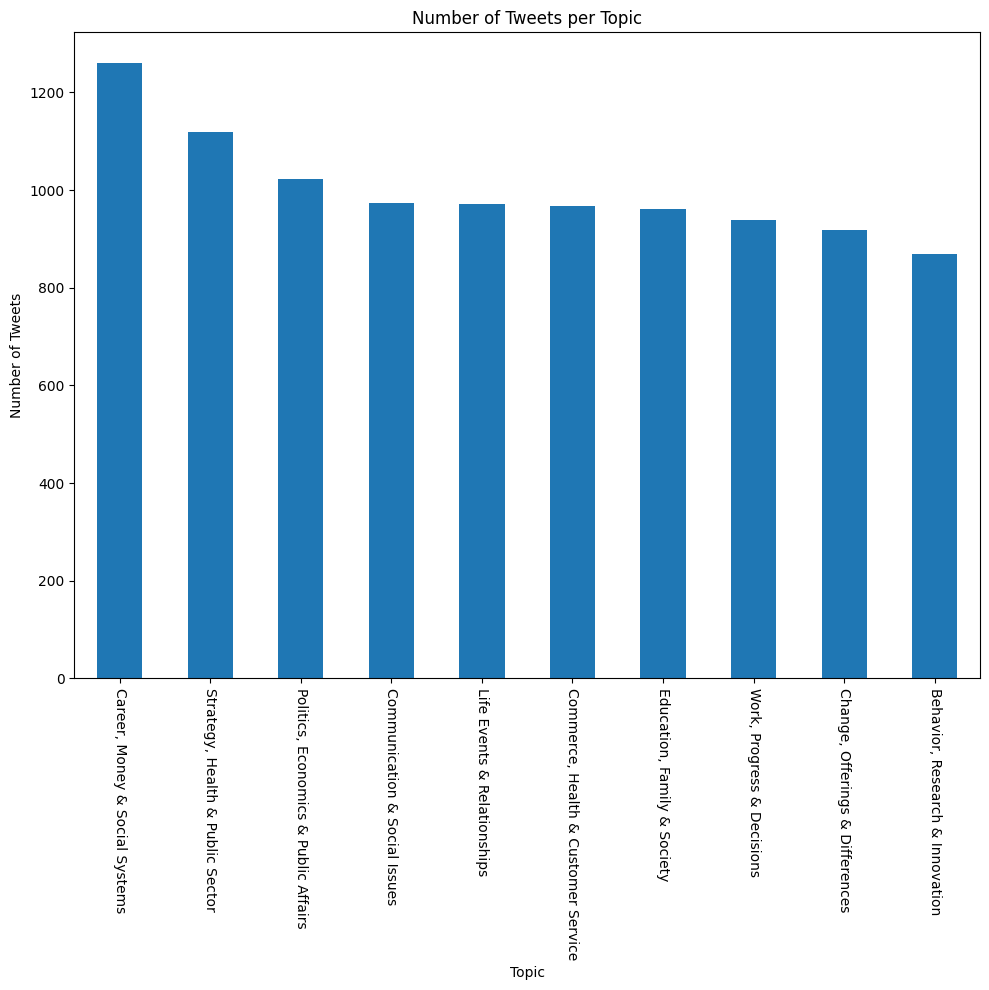

In [28]:
import matplotlib.pyplot as plt  # Import the plotting library

# Set the figure size for the plot (width, height in inches)
plt.figure(figsize=(10,10))

# Plot a bar chart of the number of tweets per topic
topic_counts.plot(kind='bar')

# Set the label for the x-axis
plt.xlabel('Topic')

# Set the label for the y-axis
plt.ylabel('Number of Tweets')

# Set the title of the plot
plt.title('Number of Tweets per Topic')

# Rotate the x-axis labels for better readability (vertical labels)
plt.xticks(rotation=270)

# Adjust the plot to ensure everything fits without overlap
plt.tight_layout()

# Display the plot
plt.show()


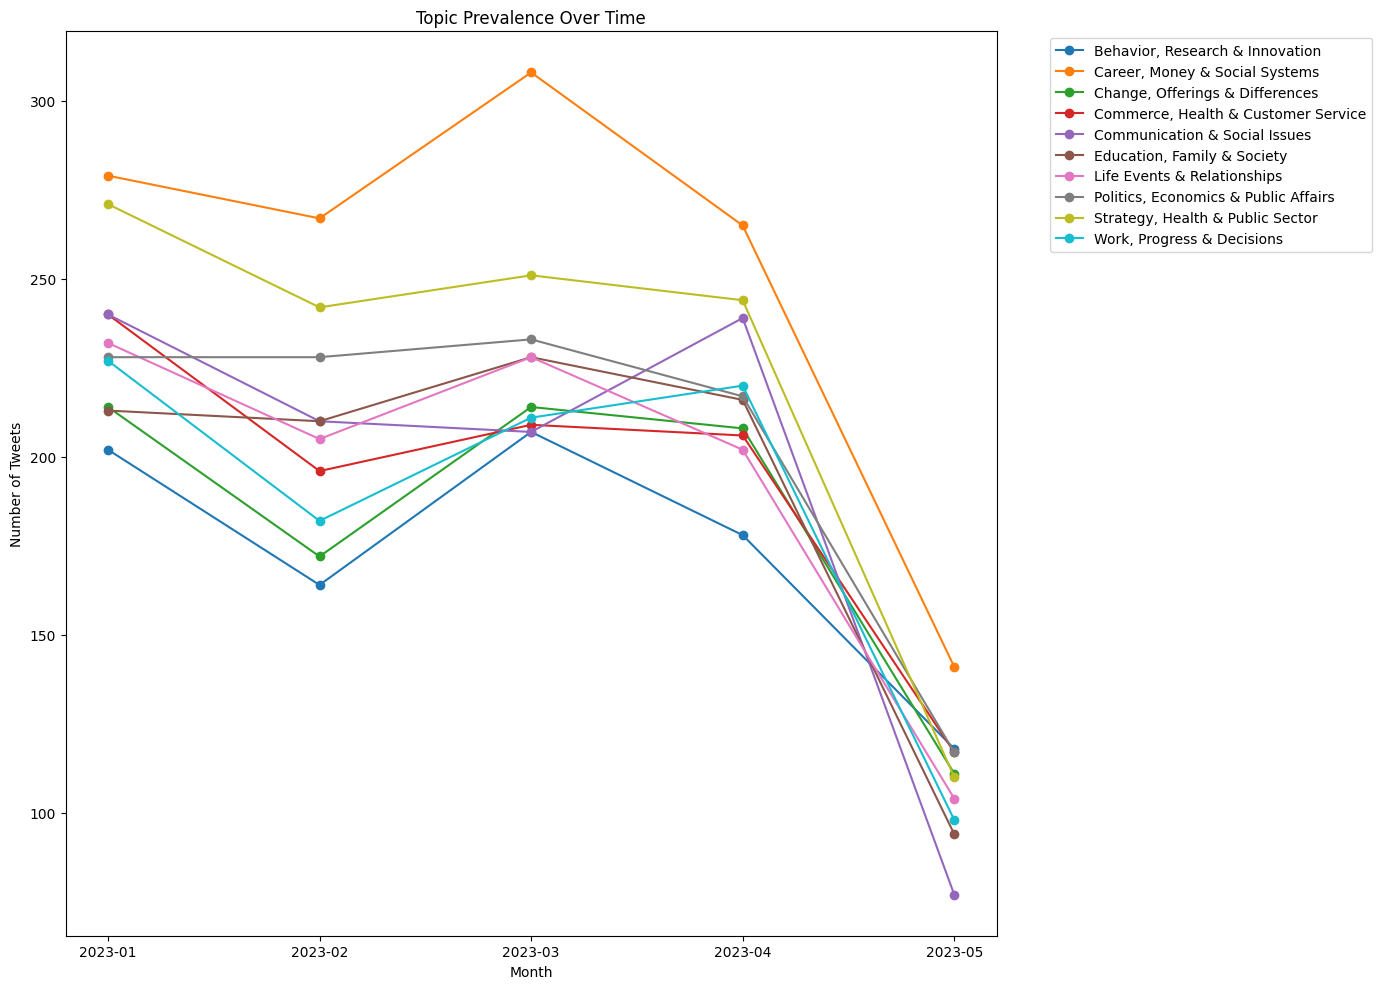

In [29]:
# Set the figure size to 14 inches wide and 10 inches tall for a large, clear plot
plt.figure(figsize=(14,10))

# Plot the number of tweets per topic over time (by month)
# Loop through each topic (column) in the table
for topic in topic_time_counts.columns:
    # Plot the trend line for this topic, with markers at each data point
    plt.plot(topic_time_counts.index, topic_time_counts[topic], marker='o', label=topic)

# Set the label for the x-axis (months)
plt.xlabel('Month')

# Set the label for the y-axis (tweet counts)
plt.ylabel('Number of Tweets')

# Set the title for the plot
plt.title('Topic Prevalence Over Time')

# Add a legend outside the plot area (on the right)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


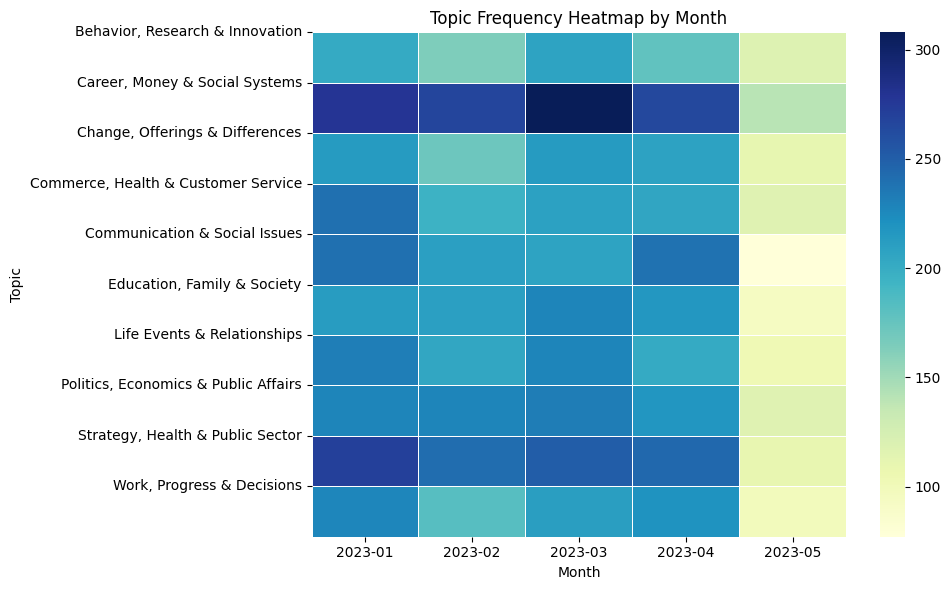

In [31]:
import seaborn as sns  # Import the seaborn library for enhanced data visualization
# If you don't have seaborn installed, run: !pip install seaborn

# Set the size of the figure (width=12 inches, height=8 inches)
plt.figure(figsize=(10,6))

# Draw a heatmap showing topic frequency by month
# - topic_time_counts.T transposes the table so topics are on the y-axis and months on the x-axis
# - cmap sets the color scheme for the heatmap
# - linewidths adds lines between cells for clarity
# - annot=False means don't write the count numbers inside the cells (for a cleaner look)
sns.heatmap(
    topic_time_counts.T,
    cmap='YlGnBu',
    linewidths=0.5,
    annot=False
)

# Set the title for the heatmap
plt.title('Topic Frequency Heatmap by Month')

# Label the x-axis as 'Month'
plt.xlabel('Month')

# Label the y-axis as 'Topic'
plt.ylabel('Topic')

# Make sure y-tick labels are readable and correspond to topic labels
plt.yticks(
    ticks=range(len(topic_time_counts.columns)),
    labels=topic_time_counts.columns,
    rotation=0
)

# Adjust layout so nothing is cut off or overlapping
plt.tight_layout()

# Display the heatmap
plt.show()


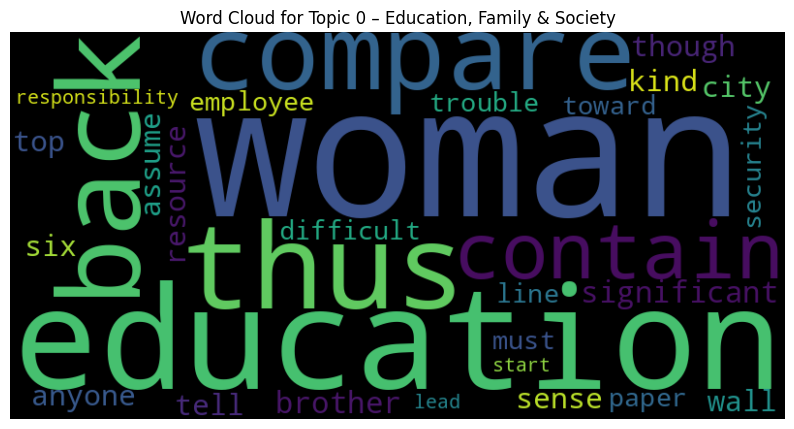

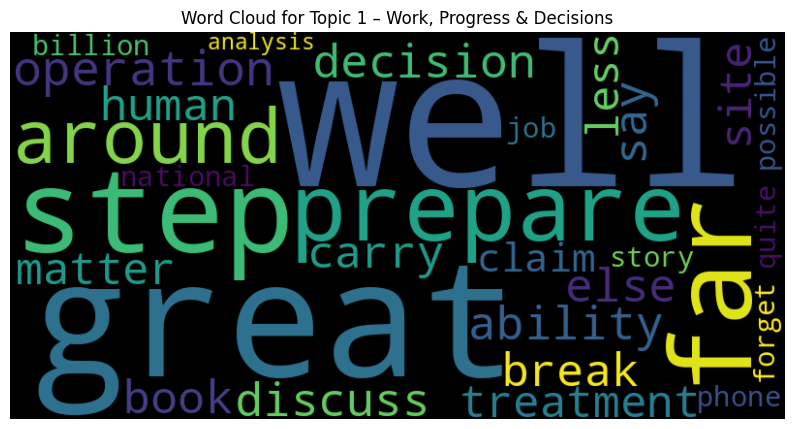

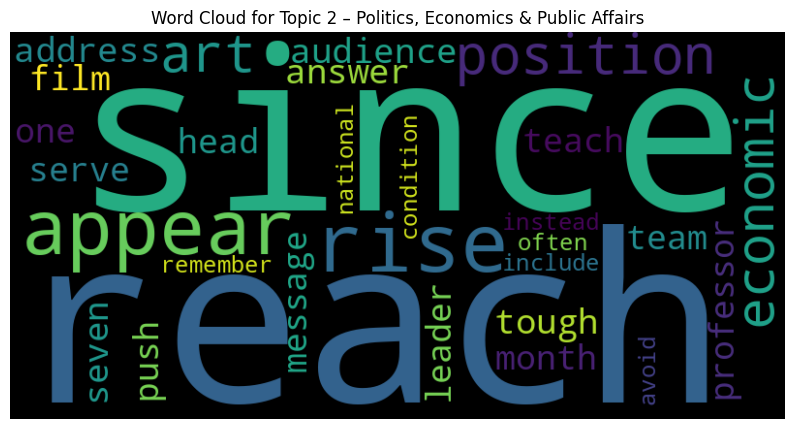

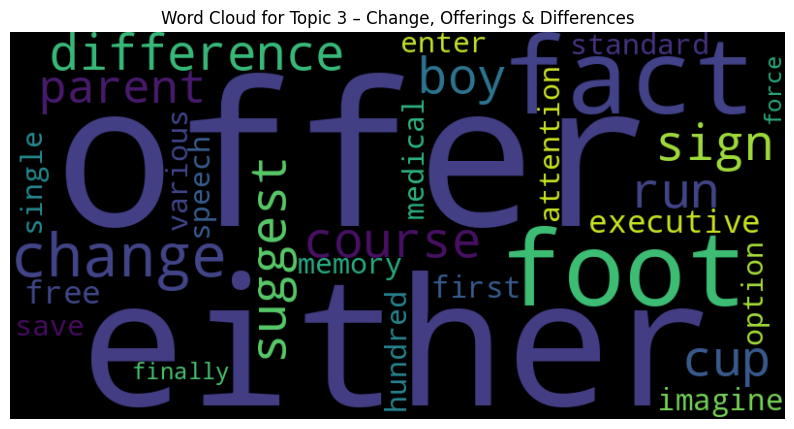

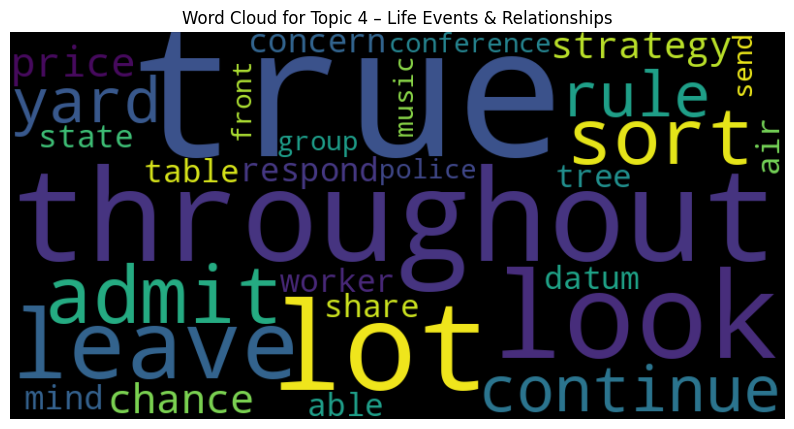

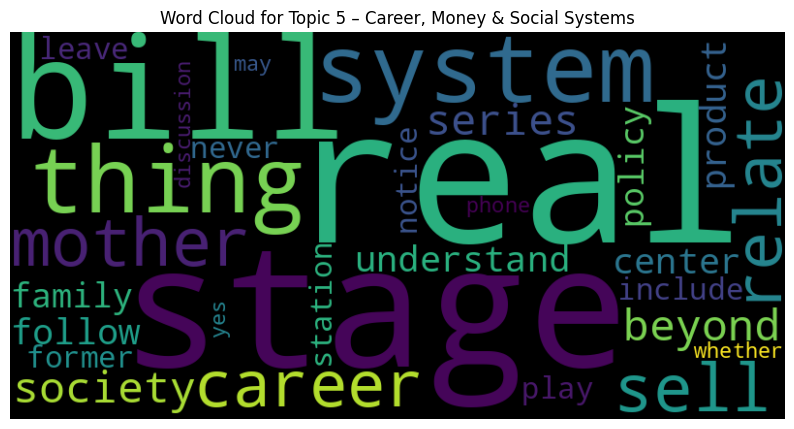

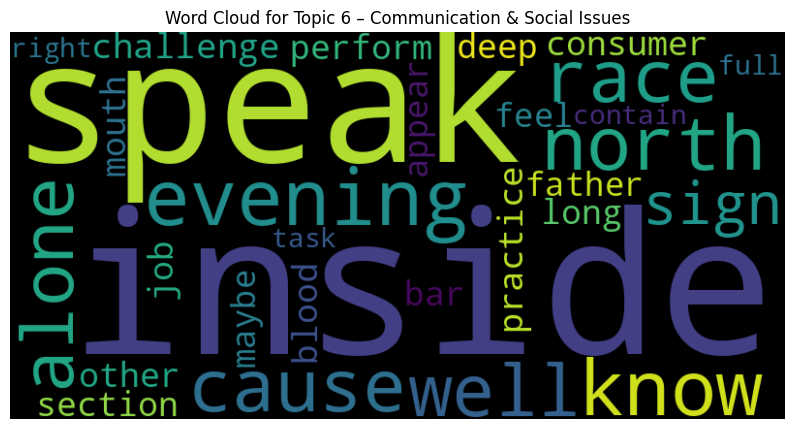

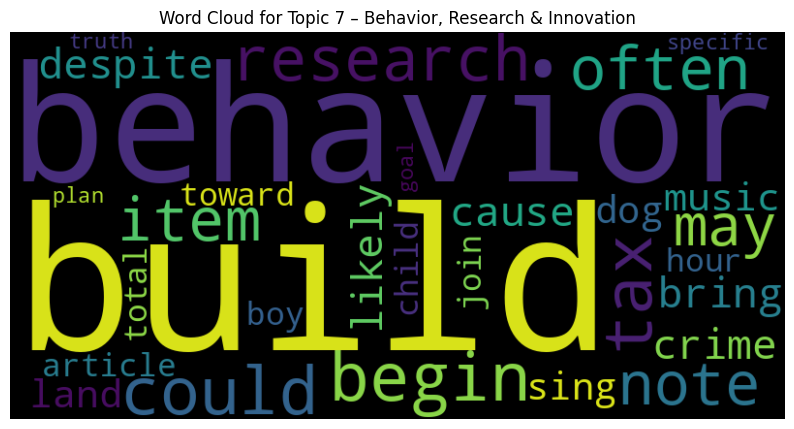

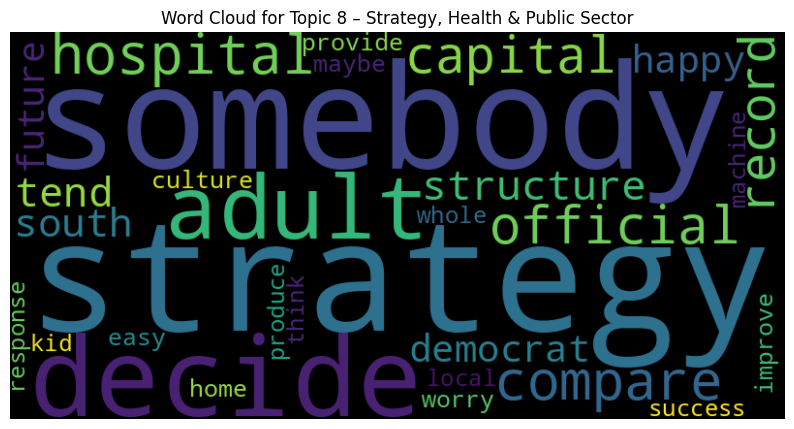

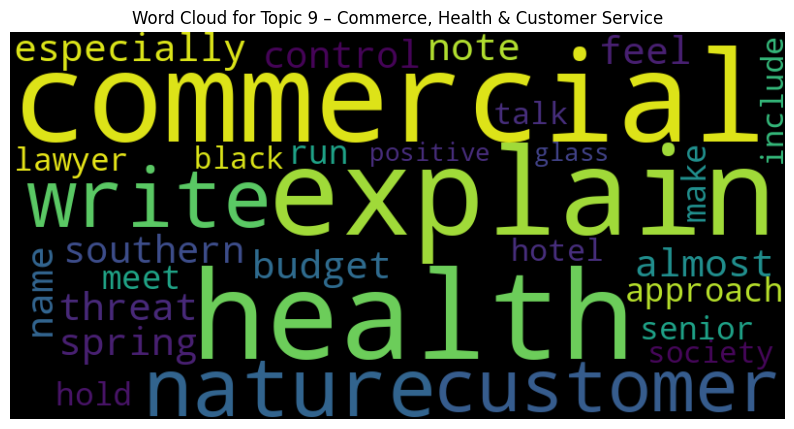

In [35]:
from wordcloud import WordCloud  # Import the WordCloud class for generating word cloud visualizations

# Loop through each topic to create a separate word cloud
for topic_num in range(NUM_TOPICS):
    # Create a new figure for each topic's word cloud (10x10 inches)
    plt.figure(figsize=(10,10))

    # Set the plot title to include the topic number and its human-readable label
    plt.title(f"Word Cloud for Topic {topic_num} – {topic_labels[topic_num]}")

    # Get the top 30 words for the topic, as a dictionary {word: weight}
    words = dict(lda_model.show_topic(topic_num, 30))  # show_topic returns list of (word, weight) pairs

    # Generate the word cloud from word frequencies
    wc = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(words)

    # Display the word cloud image on the plot
    plt.imshow(wc, interpolation='bilinear')

    # Remove axis ticks and labels for a cleaner visualization
    plt.axis('off')

    # Show the plot
    plt.show()


In [36]:
# Enable pyLDAvis for interactive topic model visualization inside the notebook
pyLDAvis.enable_notebook()

# Prepare the visualization by providing the trained LDA model, the corpus, and the dictionary
# This step processes and formats the topic model data for display
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the interactive topic visualization directly in the notebook
pyLDAvis.display(vis)



Average sentiment per topic:
Topic_Label
Commerce, Health & Customer Service     0.386692
Career, Money & Social Systems          0.398826
Strategy, Health & Public Sector        0.423461
Behavior, Research & Innovation         0.426700
Communication & Social Issues           0.433245
Politics, Economics & Public Affairs    0.440677
Education, Family & Society             0.448780
Work, Progress & Decisions              0.457583
Life Events & Relationships             0.459811
Change, Offerings & Differences         0.482543
Name: Sentiment, dtype: float64


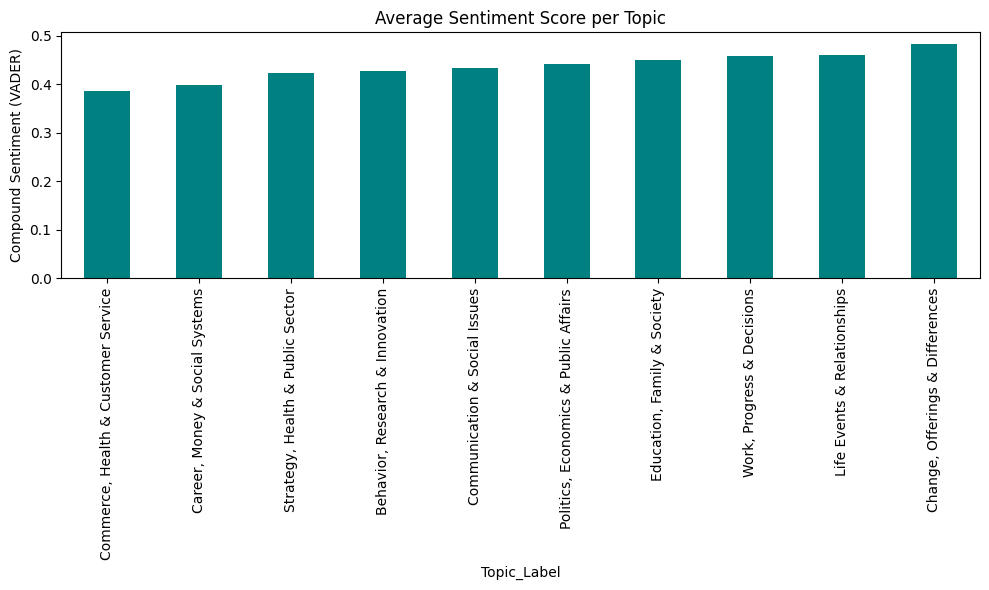

In [39]:
# If not already installed, install the VADER sentiment analysis package
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Import VADER sentiment analyzer

# Create a SentimentIntensityAnalyzer object for analyzing sentiment
analyzer = SentimentIntensityAnalyzer()

# Compute the sentiment score for each cleaned tweet
# The 'compound' score is a normalized, weighted composite score from VADER (-1=very negative, +1=very positive)
df['Sentiment'] = df['Clean_Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Calculate the average sentiment score for each topic
sentiment_per_topic = df.groupby('Topic_Label')['Sentiment'].mean().sort_values()

print("\nAverage sentiment per topic:")
print(sentiment_per_topic)  # Print average sentiment score per topic, from most negative to most positive

# Optional: Visualize the average sentiment per topic as a bar chart
plt.figure(figsize=(10,6))  # Set the plot size (10 inches wide, 5 inches tall)
sentiment_per_topic.plot(kind='bar', color='teal')  # Create a bar plot with teal bars
plt.title('Average Sentiment Score per Topic')       # Set the plot title
plt.ylabel('Compound Sentiment (VADER)')            # Set the y-axis label
plt.tight_layout()                                  # Adjust layout to prevent overlap
plt.show()                                          # Display the plot
